In [2]:
library(evir)
library(poweRlaw)
library(quantmod)
library(FinTS)

Warning message:
“package ‘poweRlaw’ was built under R version 3.5.2”
Loading required package: xts

Warning message:
“package ‘xts’ was built under R version 3.5.2”
Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Warning message:
“package ‘FinTS’ was built under R version 3.5.2”


Next we download a bunch of data for technological stocks. We start our analysis from Apple

In [3]:
tech<-getSymbols(c('AAPL','GOOGL','AMZN','TSLA','MSFT'),src="yahoo", from="2007-01-01")
dates<-index(AAPL)
aapl<-as.data.frame(AAPL)
aapl<-cbind(date=dates,aapl)
rownames(aapl)<-NULL
head(aapl)

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




,date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,AAPL.Adjusted
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2007-01-03,3.081786,3.092143,2.925000,2.992857,1238319600,2.573566
2,2007-01-04,3.001786,3.069643,2.993571,3.059286,847260400,2.630688
3,2007-01-05,3.063214,3.078571,3.014286,3.037500,834741600,2.611954
4,2007-01-08,3.070000,3.090357,3.045714,3.052500,797106800,2.624853
5,2007-01-09,3.087500,3.320714,3.041071,3.306071,3349298400,2.842900
6,2007-01-10,3.383929,3.492857,3.337500,3.464286,2952880000,2.978950


We obtain the log returns and from them the lossess and focus our further attention on them since lossess are really the things we should concentrate on

In [4]:
returns_a<-Delt(aapl$AAPL.Adjusted,type = 'log')
returns_a<-na.omit(returns_a)
losses_a=-returns_a[returns_a<0]

There are two heavy-tailed distributions we will focus on in this mini-project: power law and lognormal. Power law distribution is the true "fat tail" which is capable of producing events of extreme magnitude, hence it is very important from the risk management point of view to correctly identify whether our data has it or not. 

The PDF of the Pareto distribution (one of the particular examples of power-law probability distributions) is $f(x)=\frac{\alpha*x^\alpha_m}{x^\alpha+1}$ while CDF is $F(x)=1-(\frac{x_m}{x})^\alpha$
We can see that there are two parameters: $x_m$ is the scale, minimum possible value and $\alpha$ is the shape parameter. One of the most distinctive characteristics of the Pareto distribution is that it has infinite moments of order $\ge \alpha$. This makes this distibution exceptionaly fat-tailed and the lower is parameter $\alpha$ the fatter is the tail. Another consequence is that when theoretical moment is infinite, sample moments become unreliable for inference.

What about the log-normal distribution? It also rather commonly occurs when dealing with financial data, perhaps, even more commonly than power law. It has a PDF of $f(x)=\frac{exp(-\frac{(\log(x)-\mu)^2}{2*\sigma^2})}{x*\sigma*\sqrt(x)}$
So, it also has two parameters, $\mu$ and $\sigma$. All moments of the log-normal distribution are always finite which makes a stark contrast from the Pareto. However, the log-normal distribution can produce very heavy tails as well which is mainly controlled by the $\sigma$ parameter - the higher it is the higher are the variance and kurtosis. It also sometimes becomes pretty hard to distinguish the power-law from the log-normal, especially from the log-normal with high $\sigma$. But we will try our best.

Our next goal is to perform a bunch of graphical analysis in order to determine whether we have a power law in our data or not. We first analyze losses of Apple.

The first plot is QQ-plot which compares the data with exponential distribution. If the resulting graph is concave, our underlying distribution has heavier tails than exponential, which we exactly see on the graph.

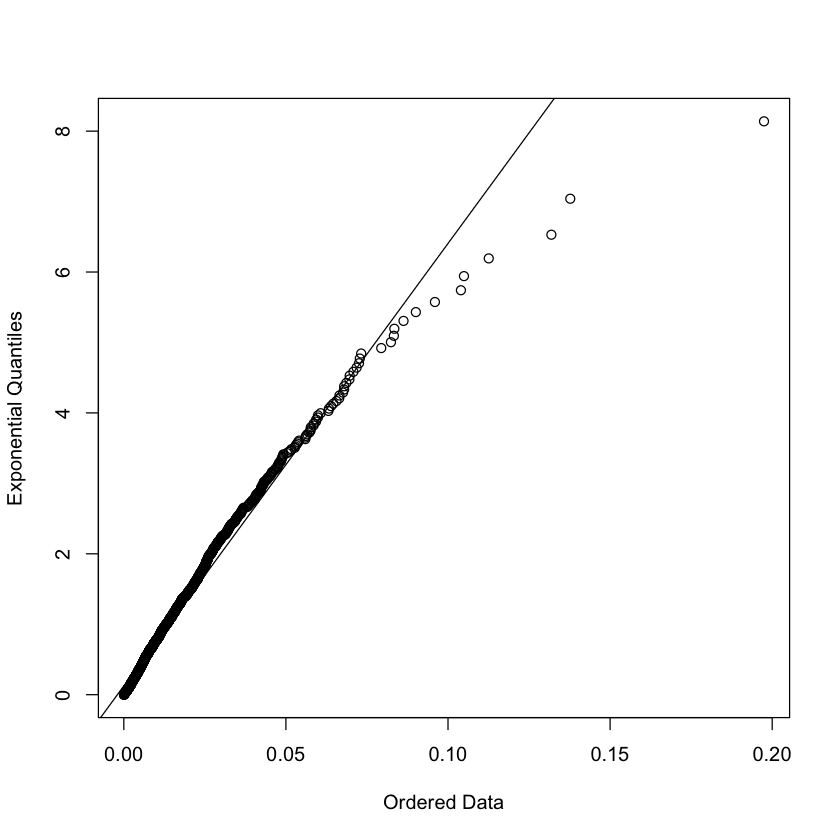

In [5]:
evir::qplot(losses_a)

The next plot is the ZIPF plot which is basically the loglog plot of the empirical survival function of our data. For the power law distribution the resulting relationship is negative and linear with respect to x: 

$$\overline{F(x)}=(\frac{x_m}{x})^\alpha =>\\
\log(\overline{F(x)})=\alpha*\log(x_m)-\alpha*\log(x)$$

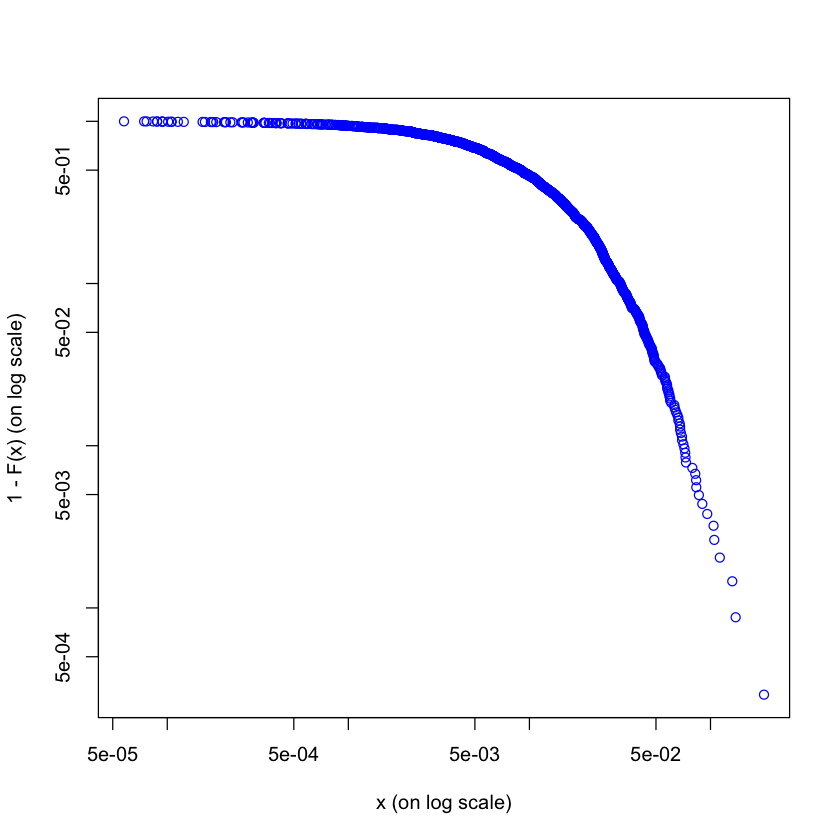

In [6]:
emplot(losses_a,'xy',col='blue')

We don't have a linear relationship, maybe only in the very tail.

The next plot is the plot of the mean excess function (MEF). For Pareto distribution the MEF is growing linearly in the threshold: $$e_{PA}(v)=\frac{v}{\alpha-1}$$

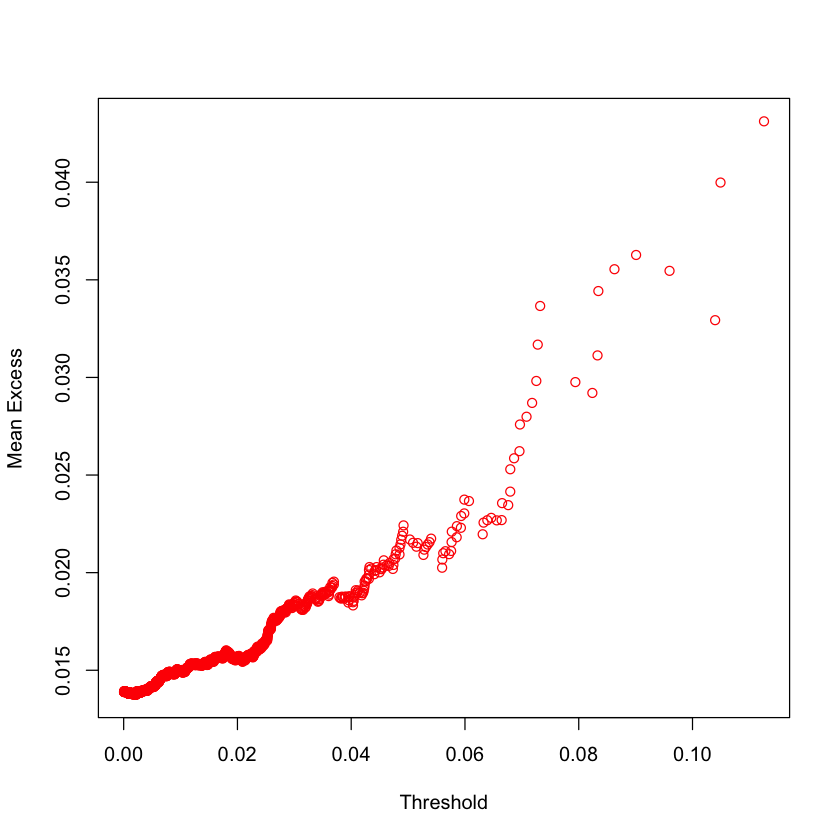

In [7]:
meplot(losses_a,col='red')

Although the relationship may not seem exactly linear, in general, long-tailed df’s exhibit an upward sloping behavior, exponential-type df’s have roughly a constant mean-excess plot, whereas short- tailed data yield a plot decreasing to 0. In our case we clearly have an upward slope signalling for the heavy tail.

Next, we create the function which plots the MS (maximum-to-sum) plot for certain number of moments. It is known that power law distribution with parameter $\alpha$ has infinite moments of order higher than $\alpha$. The MS plot helps to detect whether a moment of certain order is finite or not. It plots the quantity $R_n(p)=\frac{M_n(p)}{S_n(p)}$, where $S_n(p)=\sum_{i=1}^{n} |X_i|^{p}$ and $M_n(p)=max(|X_1|^{p},...,|X_n|^{p})$ 

If the plot converges to 0, the p'th moment is finite, whereas if the plot oscillates, the moment is infinite. In our case the function plots the behavior of this quantity for first 5 moments.

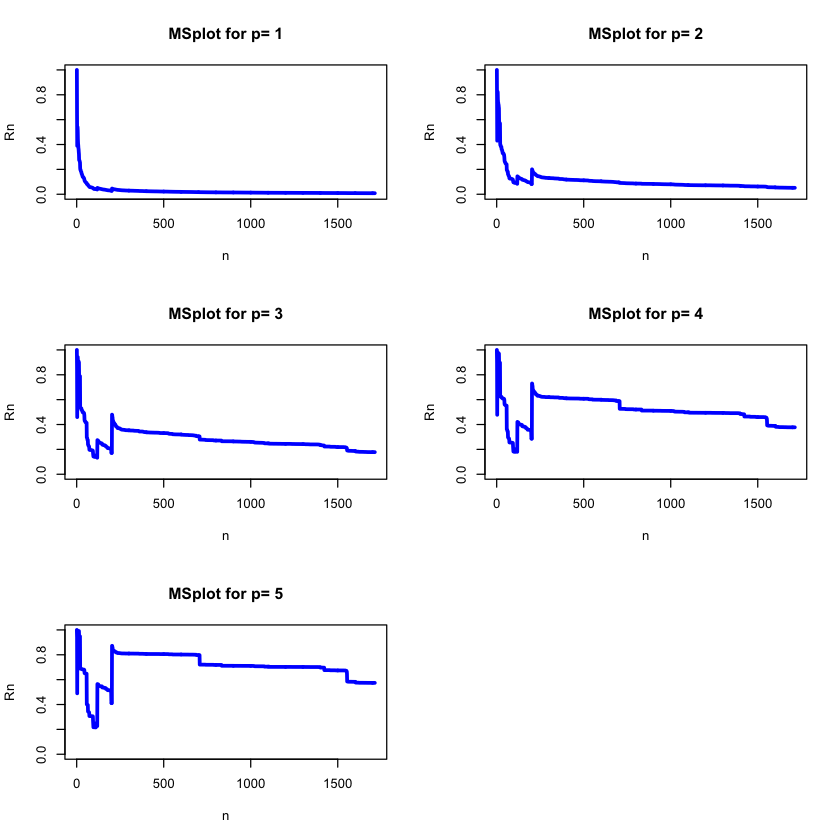

In [8]:
MSplot<- function(data,p=5) {
  par(mfrow=c(3,2))
  x=abs(data)
  for (i in 1:p) {
    y=x^i
    S=cumsum(y)
    M=cummax(y)
    R=M/S
    plot(1:length(x),R,type='l',col='blue',lwd=3,ylim=c(0,1),xlab='n',ylab='Rn',main=paste("MSplot for p=",i))
  }
  par(mfrow=c(1,1))
}
MSplot(losses_a)

Based on this graph, we could say that 5th and 4th moment may be infinite since there is no clear convergence to 0 for them. So, our $\alpha$ parameter is likely in the range between 4 and 5.

We next utilize another library - poweRlaw. It allows fitting heavy tailed distributions to the data, in particular Pareto and log-normal. We fit both distributions to our data creating continuous power-law and log-normal objects.

In [9]:
#fitting continuous power law
a_pl<- conpl$new(losses_a) 
est_a<-estimate_xmin(a_pl)
a_pl$setXmin(est_a)

#fitting continuous log-normal
a_ln=conlnorm$new(losses_a)
est2_a<-estimate_xmin(a_ln)
a_ln$setXmin(est2_a)

Now let's plot the fits on the same graph.

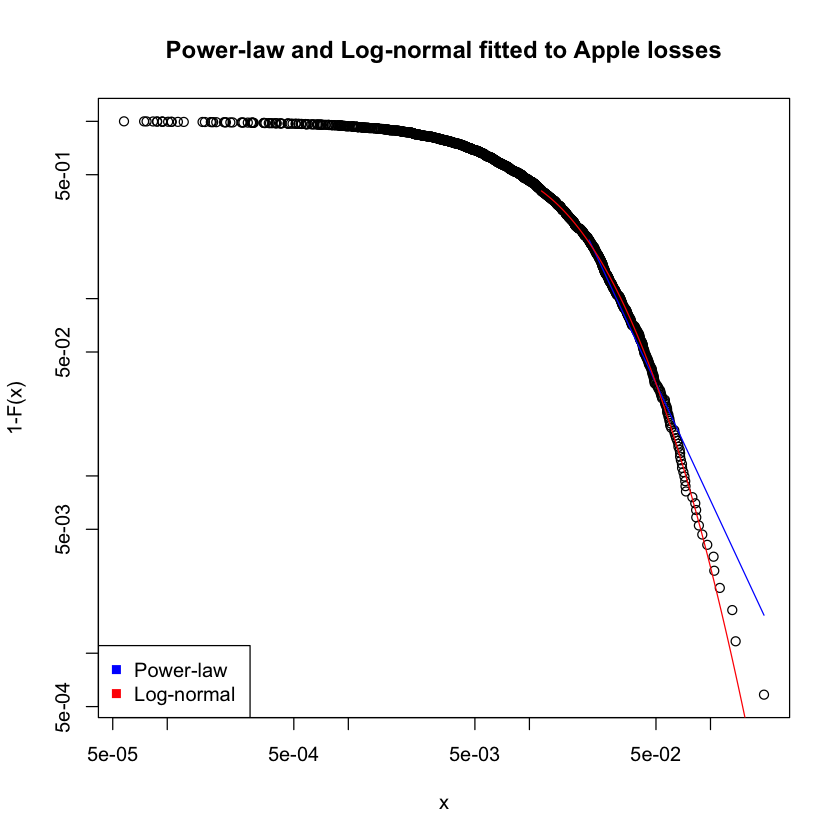

In [10]:
plot(a_pl,ylab='1-F(x)')
lines(a_pl,col=4)
lines(a_ln,col=2)
title('Power-law and Log-normal fitted to Apple losses')
legend('bottomleft',legend=c('Power-law','Log-normal'),pch=15,col = c('blue','red'))

We can see that log-normal distribution fits our data better. Let's conduct a formal statistical test to see it. We use a bootstrap with 1000 simulations and perform a Kolmogorov-Smirnov goodness-of-fit test (well, it's actually automatically performed by R for us)

In [ ]:
bs_ap=bootstrap_p(a_pl,no_of_sims = 1000,threads = 4)

We can extract KS goodness-of-fit statistic:

In [ ]:
bs_ap$gof

And the p-value:

In [ ]:
bs_ap$p

The p-value is very small indicating that we reject the null hypothesis of the test. This means that power law is **not** a valid distribution if we look at the data as a whole.
But what if we split the data into the "bulk" and "tail" and try to conduct the same test? The reason is that real-world data often exhibits mixed behavior so although we cannot really detect the power law in the data as a whole, it may well be present in the tail. So we define the tail as being all observations higher than 95th quantile:

In [11]:
loss_a_tail=losses_a[losses_a>quantile(losses_a,0.95)]

And conduct the same procedure with fitting and evaluating the power-law, but now on the tail:

In [12]:
a_pl_t=conpl$new(loss_a_tail)
est_a_t<-estimate_xmin(a_pl_t)
a_pl_t$setXmin(est_a_t)
bs_apt=bootstrap_p(a_pl_t,no_of_sims = 1000,threads = 4)

Expected total run time for 1000 sims, using 4 threads is 29.9 seconds.



Extracting the statistic and the p-value:

In [13]:
print(bs_apt$gof)
print(bs_apt$p)

[1] 0.05434612
[1] 0.872


Now we have a very high p-value, meaning that we cannot rule out the power-law for the tail. Let's look at the estimated parameters of this distribution:

In [14]:
a_pl_t$pars

[1] 4.760027

The estimated value of the $\alpha$ is slightly less than 5. Let's plot the fit on the graph:

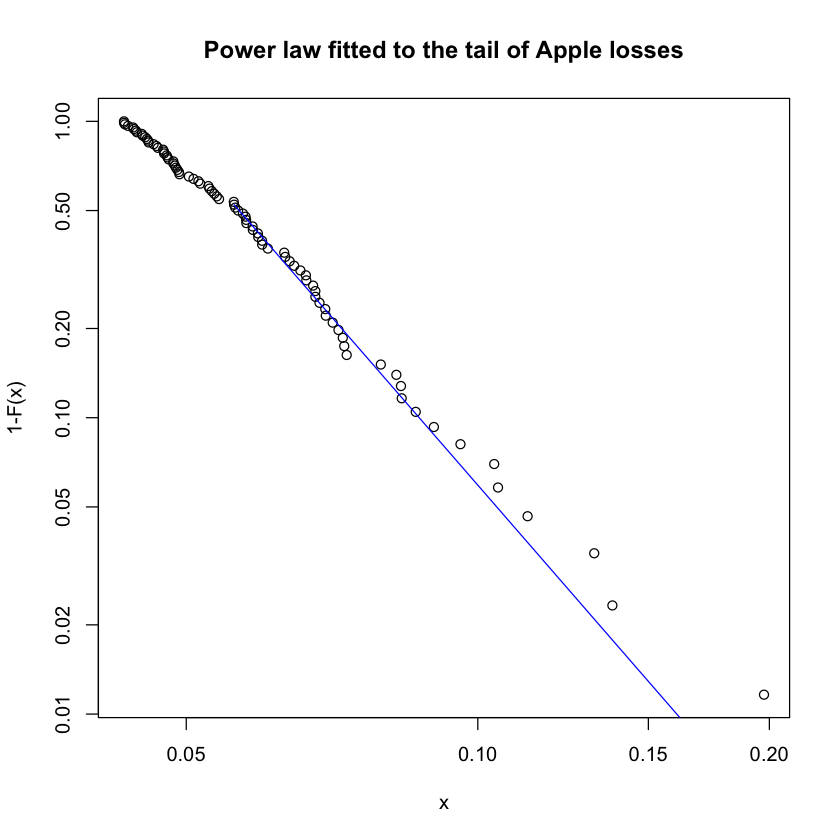

In [15]:
plot(a_pl_t,ylab='1-F(x)')
lines(a_pl_t,col=4)
title('Power law fitted to the tail of Apple losses')

We see that now the relationship is much closer to linear which is the sign of a power law. However, this fit doesn't seem extremely good: we are unable to correctly detect the observation in the very tail. For the given probability (around 0.01) we estimate event of significantly lesser magnitude that actually happened (0.15 instead of 0.2). This may lead to a conclusion that $\alpha$ parameter should be a bit less than estimated value of 4.7.

Let's produce a Hill plot - graph often used to infer the value of the $\alpha$. It shows the dependence of this parameter as a function of the threshold. The true value of the $\alpha$ corresponds to the point where the plot more or less "stabilizes".

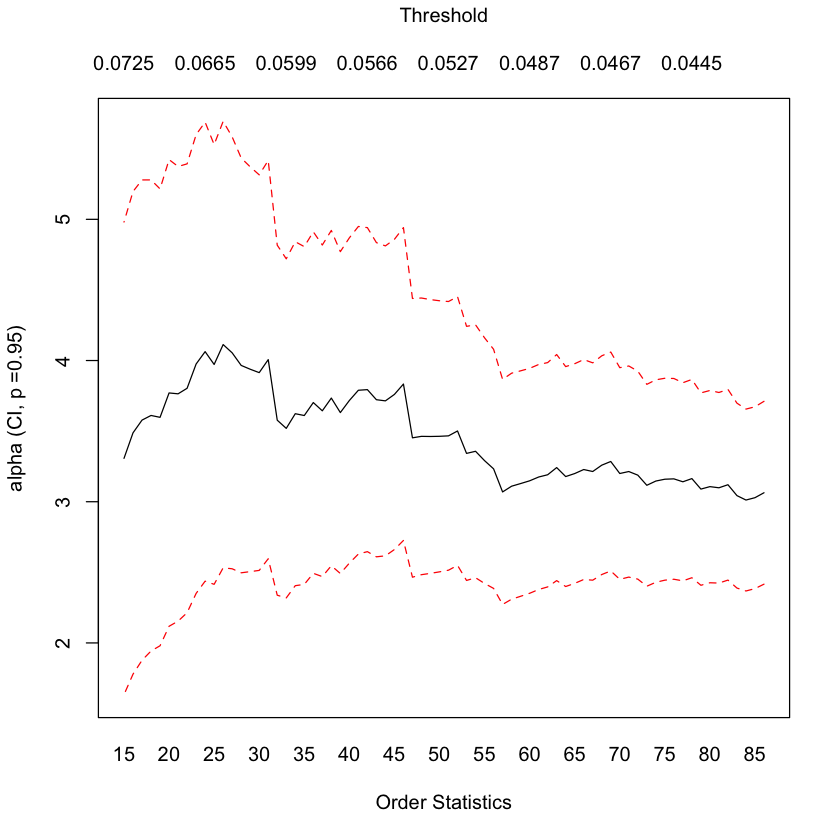

In [16]:
hill(loss_a_tail)

In our case I would say that it is happening around $\alpha \approx$ 3-3.5. These values correspond to approximate threshold of 0.056, so we fit the GPD with it.

In [17]:
fit=gpd(loss_a_tail,threshold = 0.056)
tail(fit)

0.0416242242,-4.715844e-04
-0.0004715844,1.262356e-05


Our $\xi$ parameter (which is the inverse of $\alpha$) is around 0.2975 which means that $\alpha \approx$ 3.36 which is in line with our initial guesses. The fit, however, is not extremely good as the value of $\xi$ parameter is not significant (at least on 90% level).

Let us now plot the fitted object. "Evir" package offers 4 different plots: excess distribution, tail of underlying distribution, scatterplot of the residuals and QQplot of the residuals. We exploit all these.

In [19]:
plot(fit)


ERROR: Error in menu(tmenu, title = "\nMake a plot selection (or 0 to exit):"): menu() cannot be used non-interactively


Unfortunately, Jupyter doesn't have interactive stuff needed for this function and some additional things need to be done for that to work properly. I put all of the above graphs into the ReadMe file. But (trust me) from them we can see that we made a pretty good fit to the data

What is interesting, all our fitting is made already on the **tail** of the data, not on the data as a whole. This means that the ***tail of the tail*** follows the power law.